## HeisenbergXX

This repository is focussed on studying inhomogeneous Heisenberg XX spin-1/2 chains. These are 1D magnetic quantum systems with the following Hamiltonian:

$$
H=-\frac{1}{2}\sum_{n=0}^{N-2}J_n(\sigma_n^x\sigma_{n+1}^x+\sigma_n^y\sigma_{n+1}^y)-\frac{1}{2}\sum_{n=0}^{N-1}B_n(1-\sigma_n^z)
$$

It is equivalent via Jordan-Wigner transformation to the following fermionic Hamiltonian:

$$
H = -\sum_{n=0}^{N-2}J_n(c^\dagger_n c_{n+1} + c^\dagger_{n+1}c_n)-\sum_{n=0}^{N-1}B_nc_n^\dagger c_n
$$

Our goal will be to numerically diagonalise them and, for the ground state at a given excitation filling $M\leq N$, to calculate two point correlations and block entanglement entropy.

Let us import some necessary Python libraries. This repository uses pandas, SciPy, NumPy and Matplotlib.

In [39]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

We also have defined a class called `SpinChain` which interfaces with our numerical code and makes using it easier. We will in a moment explain how it works.

In [23]:
import sys
sys.path.append('src')
from src.utils import SpinChain

Finally, our numerical code has been written in Fortran. In order to use it we must compile it.

Execute commands similar to the ones below. This requires a Fortran compiler as well as `BLAS` and `LAPACK` installations. Swap the name of the compiler for whichever one you have on your machine, and link to the installed libraries appropriately. 

In [24]:
from subprocess import call
call(['gfortran', 'spin_chain.f90', '-O3', '-llapack', '-o', 'spin_chain'], cwd='src')
call(['gfortran', 'correl.f90', '-O3', '-lblas', '-llapack', '-o', 'correl'], cwd='src')

0

#### Diagonalising chains

First, let us see how we can define a spin chain. This requires a specification of the number of particles $N$, as well as the inhomogeneous couplings $J_n$ and external field $B_n$ at each lattice site.

Note that $J_n$ should be strictly positive, and have length $N-1$.

In [25]:
N = 600
x = np.arange(N) / N
J = np.sin(np.pi * x) * x**3 + 1/N
J = J[:-1]
B = np.zeros_like(x)

chain = SpinChain(N, J, B)

The first operation that we can perform on this chain is diagonalising it. This produces the chain's eigenvalues and eigenstates, as well as some information pertaining to orthogonal polynomials.

The diagonalised Hamiltonian reads

$$
H=\sum_{k=0}^{N-1}\varepsilon_k\tilde{c}_k^\dagger \tilde{c}_k
$$

for some energies $\varepsilon_k$ and fermionic operators $\tilde{c}_k$, defined through the eigenvectors $\phi_n(\varepsilon_k)$

$$
\tilde{c}_k = \sum_{n=0}^{N-1}\phi_n(\varepsilon_k)c_n
$$

In [26]:
chain.diagonalise()

In [27]:
# The chain's spectrum:
truncate = 10

chain.E[:truncate]

array([-0.6056  , -0.600138, -0.594706, -0.589304, -0.583932, -0.578591,
       -0.57328 , -0.567998, -0.562747, -0.557525])

Text(0, 0.5, '$\\phi_n(\\varepsilon_{20})$')

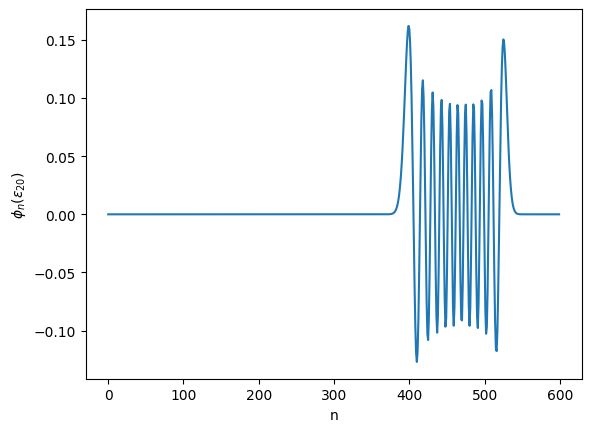

In [28]:
# kth eigenvector
k = 20

plt.plot(chain.Phi[:, k])
plt.xlabel('n')
plt.ylabel(fr'$\phi_n(\varepsilon_{{{k}}})$')

#### Calculating correlations

Next we can calculate correlations in the chain. This requires specifying a state to calculate them in. In particular, we're interested in the $M$ particle ground state:

$$
|M\rangle = \prod_{k=0}^{M-1}\tilde{c}_k^\dagger|0\rangle
$$

Our programme calculates the correlation matrix $C_{nm}=\langle M|c^\dagger_n c_m|M\rangle$ and, from it, the block entanglement entropy $S_\alpha$. 

The system's (presumably entangled) ground state density matrix is $\rho=|M\rangle\langle M|$. Given a bipartition of our spin system into contiguous blocks $A\cup\bar{A}$, $A=\{0,1,...,L-1\}$, the system's (mixed) reduced density matrix is $\rho_A=\mathrm{tr}_{\bar{A}}(\rho)$. From it, we define the block entanglement entropy as

$$
S_\alpha = \frac{1}{1-\alpha}\log\mathrm{tr}(\rho_A^\alpha)
$$

In [29]:
M = N//2
chain.filling(M)

Diagonalising L = 600 / 600


Text(0.5, 1.0, '$\\langle c^\\dagger_n c_m\\rangle$')

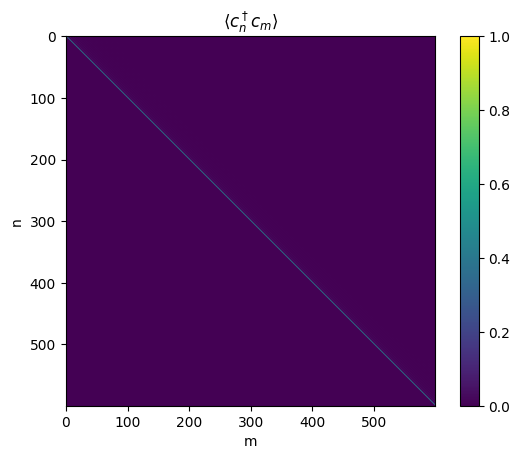

In [38]:
# Correlation matrix
plt.imshow(chain.C, cmap='viridis', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('m')
plt.ylabel('n')
plt.title(r'$\langle c^\dagger_n c_m\rangle$')

Text(0, 0.5, 'S')

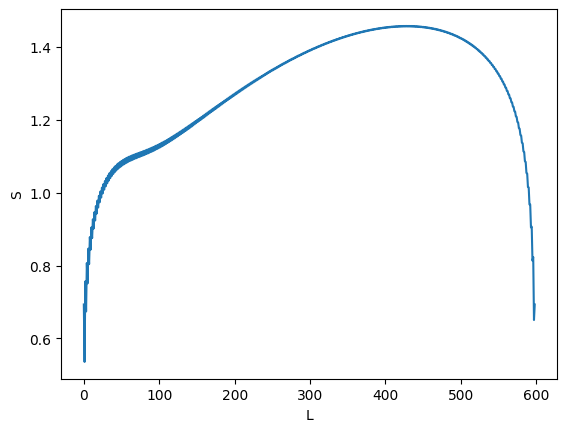

In [35]:
plt.plot(chain.S()[:-1])
plt.xlabel('L')
plt.ylabel('S')

Finally, there exist some analytical results which tell us what the entanglement entropy of a chain should be at half-filling. In particular $S_\alpha = c'_\alpha + S^0_\alpha + S^1_\alpha$. The first term is a non-universal constant which we fit as follows:

$$
c'_\alpha = \frac{1}{N}\sum_{L=0}^{N-1}(S_\alpha(L)-S^0_\alpha(L))
$$

The other other two terms are functions of $\tilde{x}$.

$$
\tilde{x} = \frac{N}{2}\int_0^x\frac{\mathrm{d}s}{J(s)}
$$

In [73]:
x = N/2 * cumulative_trapezoid(1/chain.J, dx=1/N, initial=0) + 1/N

x = np.append(x, [x[-1]])
chain.isothermal_length(x, 'l')

S = chain.S()[:-1]
c = np.mean(S - chain.S0())
S_CFT = c + chain.S0() + chain.S1()

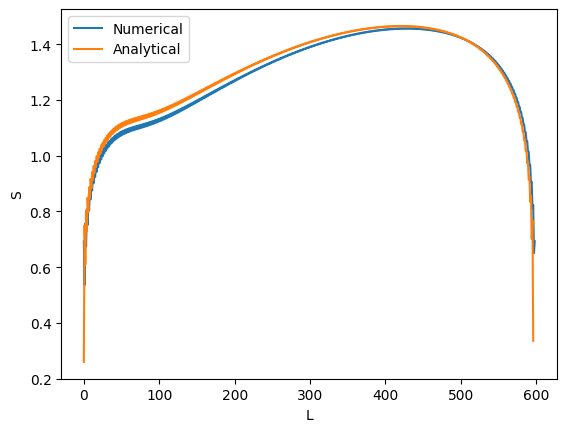

In [75]:
plt.plot(S, label='Numerical')
plt.plot(range(N-3), S_CFT[1:-1], label='Analytical')
plt.xlabel('L')
plt.ylabel('S')
plt.legend()